In [1]:
# /kaggle/input/playground-series-s4e12/sample_submission.csv
# /kaggle/input/playground-series-s4e12/train.csv
# /kaggle/input/playground-series-s4e12/test.csv

import pandas as pd

train_df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv", index_col = 'id', engine='pyarrow').dropna(subset=['Premium Amount'])
test_df = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv", index_col = 'id', engine='pyarrow')
target = 'Premium Amount'

In [2]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
reference_date = datetime(2018,1,1)
def add_custom_transform(df):
    df = df.copy()
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['DaysSinceStart'] = (df['Policy Start Date'] - reference_date).dt.days
    df = df.drop(columns = ['Policy Start Date'])
    return df

train_df = add_custom_transform(train_df)
test_df = add_custom_transform(test_df)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold
import numpy as np

numeric_features = np.setdiff1d(train_df.select_dtypes(include=np.number).columns.values, ['Premium Amount'])
categorical_features = train_df.select_dtypes(include='object').columns.values
# train_df[numeric_features].describe().T
# train_df[categorical_features].describe().T
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# different models 
linear_model = LinearRegression()
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=1)
mlp_model = MLPRegressor(max_iter=400, random_state=1)
xgb_model = XGBRegressor(
    n_estimators=80,
    learning_rate=0.05,
    max_depth=25,
    random_state=1
)
voting_model = VotingRegressor(estimators=[
    ('Elastic', elastic_model),
    ('XGB', xgb_model),
    ('MLP', mlp_model),
    ('Linear', linear_model)
])

# pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', voting_model)
])


In [4]:
x = train_df.drop(columns=[target])
y = np.log1p(train_df[target])
x_train_full, x_test_final, y_train_full, y_test_final = train_test_split(
    x, y, test_size=0.2, random_state=3
)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
fold = 1
mse_scores = []

for i_train, i_val in kf.split(x_train_full):
    print(f"Fold {fold}")
    x_train, x_val = x_train_full.iloc[i_train], x_train_full.iloc[i_val]
    y_train, y_val = y_train_full.iloc[i_train], y_train_full.iloc[i_val]
    
    # train
    model_pipeline.fit(x_train, y_train)
    # predict
    y_val_pred = model_pipeline.predict(x_val)
    
    mse = mean_squared_error(y_val, y_val_pred)
    mse_scores.append(mse)
    print(f"MSE for Fold {fold}: {mse}")
    fold += 1
# avg mse calculation
avg_mse = np.mean(mse_scores)
print(f"Average MSE: {avg_mse}")

model_pipeline.fit(x_train_full, y_train_full)
y_test_pred = model_pipeline.predict(x_test_final)
test_mse = mean_squared_error(y_test_final, y_test_pred)
print(f"Test MSE: {test_mse}")


results_df = pd.DataFrame({
    "Actual": y_test_final.values,
    "Predicted": y_test_pred
})

Fold 1
MSE for Fold 1: 1.1444108965012014
Fold 2
MSE for Fold 2: 1.137011537004621
Fold 3
MSE for Fold 3: 1.147174286067877
Fold 4
MSE for Fold 4: 1.1374659731648287
Fold 5
MSE for Fold 5: 1.1411166873863863
Average MSE: 1.141435876024983
Test MSE: 1.147723581246434


In [5]:
# Test prediction
y_pred_test = model_pipeline.predict(test_df)
y_pred_test = np.expm1(y_pred_test)

output_file = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
output_file[target] = y_pred_test
output_file.to_csv("submission_k_fold_voting.csv", index=False)
print("submission file saved successfully")

submission file saved successfully


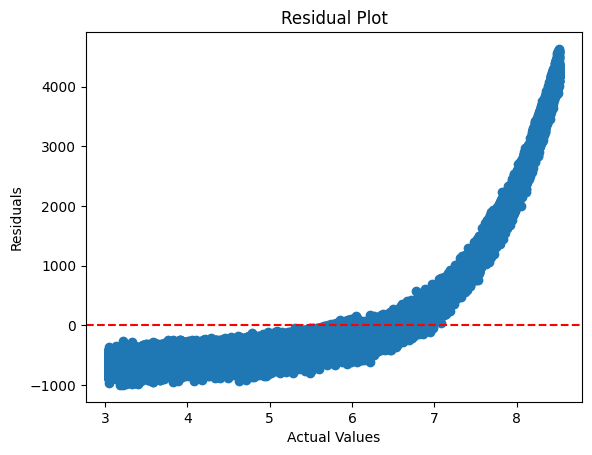

In [6]:
import matplotlib.pyplot as plt

plot_y_test = np.expm1(y_test_final)
plot_y_pred = np.expm1(y_test_pred)
residuals = plot_y_test - plot_y_pred
plt.scatter(y_test_final, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()